<a href="https://colab.research.google.com/github/Kennedy87670/Other_Project/blob/main/Paddy_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

In [2]:
# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Listing out all competition datasets in kaggle
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         42           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         69           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        582           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge         98           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1127           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13357           False  
house-pr

In [4]:
!kaggle competitions download -c paddy-disease-classification

100% 1.01G/1.02G [00:18<00:00, 72.3MB/s]
100% 1.02G/1.02G [00:18<00:00, 58.2MB/s]


In [ ]:
# Unzipping downloaded data
! unzip paddy-disease-classification.zip

In [6]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-20 19:28:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-09-20 19:28:18 (15.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [11]:
import tensorflow as tf


In [12]:
# Setting up paths to directories
train_dir="train_images"
test_dir="test_images"

In [13]:
walk_through_dir('train_images')

There are 10 directories and 0 images in 'train_images'.
There are 0 directories and 337 images in 'train_images/bacterial_panicle_blight'.
There are 0 directories and 380 images in 'train_images/bacterial_leaf_streak'.
There are 0 directories and 965 images in 'train_images/brown_spot'.
There are 0 directories and 1594 images in 'train_images/hispa'.
There are 0 directories and 479 images in 'train_images/bacterial_leaf_blight'.
There are 0 directories and 1764 images in 'train_images/normal'.
There are 0 directories and 620 images in 'train_images/downy_mildew'.
There are 0 directories and 1738 images in 'train_images/blast'.
There are 0 directories and 1442 images in 'train_images/dead_heart'.
There are 0 directories and 1088 images in 'train_images/tungro'.


In [14]:
# Loading in training data into batches from directory and spliting it into training and validation set
IMG_SIZE=(224,224)
train_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       subset="training")

valid_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       subset="validation")

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [15]:
# Getting class_names
class_names=train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


## Visualizing training images

In [31]:
# Creating a function to visualize random images from training data
# Importing matplotlib library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images(target_dir):
  plt.figure(figsize=(10,10))
  for i in range(8):
    plt.subplot(4,4,i+1)
    target_class=random.choice(class_names)
    target_folder=target_dir+"/"+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    print(random_image)
    target_image=target_dir+"/"+target_class+"/"+random_image[0]

    # Reading in and plotting image using matplotlib
    img=mpimg.imread(target_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

['109123.jpg']
['105371.jpg']
['101940.jpg']
['110054.jpg']
['105758.jpg']
['102202.jpg']
['106539.jpg']
['105119.jpg']


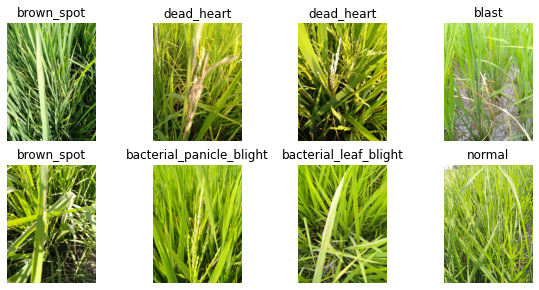

In [32]:
# Visualizing random images from training data
view_random_images("train_images")

## setup for modelling

In [39]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# Creating ModelCheckpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint/',
                                                    save_weights_only=True,
                                                    save_freq="epoch")

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training



## Setting mixed precision 
for float 64

In [40]:
# Importing mixed precision
from tensorflow.keras import mixed_precision

# Setting up mixed precision training in order to make training run faster and use less memory
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [54]:
from tensorflow.keras import layers

# create base model
input_shape = (224, 224, 3)
base_model =tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name= "input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False)  # set base_model to inference mode only
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pool")(x)
x= tf.keras.layers.Dense(128,  activation='relu')(x)
x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)




In [55]:
# Get a summary of model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pool (Global  (None, 1280)             0         
 AveragePooling2D)                                               
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 softmax_float32 (Activation  (None, 10)               0         
 )                                                         

In [56]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

initial_epoch =15
# fitting model
history = model.fit(train_data,
                    epochs= initial_epoch,
                    steps_per_epoch=len(train_data),
                    validation_data = valid_data,
                    validation_steps =len(valid_data),
                    callbacks=[create_tensorboard_callback("training_logs", "efficientb1 Paddy disease_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements
                                                              


Saving TensorBoard log files to: training_logs/efficientb1 Paddy disease_all_data_fine_tuning/20220920-210120
Epoch 1/15
261/261 [==============================] - 37s 111ms/step - loss: 1.2579 - accuracy: 0.5796 - val_loss: 0.9870 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 2/15
261/261 [==============================] - 27s 103ms/step - loss: 0.7984 - accuracy: 0.7442 - val_loss: 0.7693 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/15
261/261 [==============================] - 28s 104ms/step - loss: 0.6182 - accuracy: 0.8102 - val_loss: 0.6139 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 4/15
261/261 [==============================] - 27s 102ms/step - loss: 0.4940 - accuracy: 0.8487 - val_loss: 0.5533 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 5/15
261/261 [==============================] - 27s 103ms/step - loss: 0.4084 - accuracy: 0.8787 - val_loss: 0.4922 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 6/15
261/261 [==============================] - 27s 103ms/step - loss: 0.3404 - accuracy: 0.89

## Check the performance of the feature extraction model on validation data

In [57]:
# Evaluating feature extraction model
result_feature_extraction=model.evaluate(valid_data)
result_feature_extraction

66/66 [==============================] - 6s 77ms/step - loss: 0.2905 - accuracy: 0.9154


[0.29047954082489014, 0.9154253005981445]

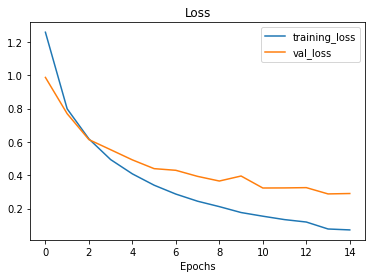

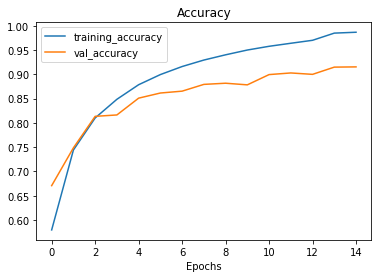

In [58]:
# PLot loss cures
plot_loss_curves(history)

In [59]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb1 True float32 <Policy "mixed_float16">
global_average_pool True float32 <Policy "mixed_float16">
dense_4 True float32 <Policy "mixed_float16">
dense_5 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


IMproving the performance of feature extraction model by fine-funing the last 10 layers

In [60]:
# Setting base_model to trainable
base_model.trainable=True

# Freezing all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [61]:
# Checking layers in base_model
for num,layer in enumerate(base_model.layers):
  print(num,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_s

In [62]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

fine_tune_epoch = initial_epoch + 10
# fitting model
history_10_layer = model.fit(train_data,
                    epochs= fine_tune_epoch,
                    steps_per_epoch=len(train_data),
                    validation_data = valid_data,
                    validation_steps =len(valid_data),
                    initial_epoch=history.epoch[-1],
                    callbacks=[create_tensorboard_callback("training_logs", "efficientb1 Paddy disease_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements
                                                              


Saving TensorBoard log files to: training_logs/efficientb1 Paddy disease_all_data_fine_tuning/20220920-211041
Epoch 15/25
261/261 [==============================] - 39s 113ms/step - loss: 0.5645 - accuracy: 0.8304 - val_loss: 0.4417 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 16/25
261/261 [==============================] - 28s 104ms/step - loss: 0.1902 - accuracy: 0.9378 - val_loss: 0.4057 - val_accuracy: 0.8751 - lr: 0.0010
Epoch 17/25
261/261 [==============================] - 28s 105ms/step - loss: 0.1254 - accuracy: 0.9616 - val_loss: 0.3436 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 18/25
261/261 [==============================] - 28s 106ms/step - loss: 0.0922 - accuracy: 0.9724 - val_loss: 0.3384 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 19/25
261/261 [==============================] - 28s 105ms/step - loss: 0.0539 - accuracy: 0.9855 - val_loss: 0.3237 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 20/25
261/261 [==============================] - 28s 106ms/step - loss: 0.0739 - accuracy

# Checking the performance of the fine tuned model on validation data

In [63]:
# Evaluating fine-tuned model
result_last_10_layers=model.evaluate(valid_data)
result_last_10_layers

66/66 [==============================] - 6s 80ms/step - loss: 0.2555 - accuracy: 0.9471


[0.2555144727230072, 0.9471408128738403]

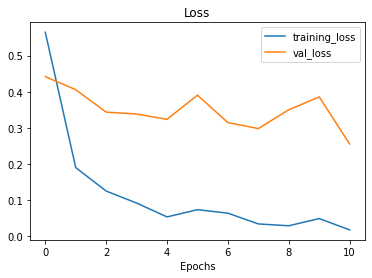

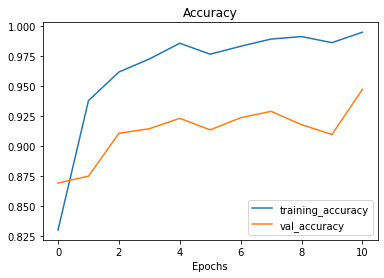

In [64]:
#plot loss curve 
plot_loss_curves(history_10_layer)

## Making predictions on test data 

In [65]:
# Loading test data into batches from directory in order to make predictions on it 
test_data=tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                      label_mode=None,
                                                      image_size=IMG_SIZE,
                                                      seed=42,
                                                      shuffle=False)

Found 3469 files belonging to 1 classes.


In [66]:
# Making predictions on test_data
pred_prob=model.predict(test_data,batch_size=32,verbose=1)
pred_prob

109/109 [==============================] - 12s 86ms/step


array([[8.9196625e-08, 8.5586616e-10, 1.8244446e-15, ..., 9.9999917e-01,
        4.0586487e-10, 4.0671906e-09],
       [2.5197250e-10, 4.5271262e-10, 1.3699507e-10, ..., 2.8342720e-07,
        9.9986136e-01, 1.3819325e-04],
       [1.7847599e-06, 3.4062739e-07, 7.7224195e-06, ..., 2.1941320e-03,
        2.2549555e-03, 2.9258175e-05],
       ...,
       [3.3245362e-12, 1.0815905e-11, 2.1757051e-13, ..., 2.3641746e-06,
        9.9999654e-01, 1.5898602e-08],
       [2.2583013e-08, 9.9940109e-01, 1.3200280e-07, ..., 7.9166413e-05,
        1.4471541e-06, 3.4445268e-06],
       [5.2507834e-25, 8.2954499e-23, 6.2429108e-17, ..., 3.8516282e-14,
        4.8154538e-16, 1.1983034e-18]], dtype=float32)

In [67]:
# Getting the highest predicted probabilites
pred=pred_prob.argmax(axis=1)
pred,pred.shape

(array([7, 8, 3, ..., 8, 1, 5]), (3469,))

In [68]:
# Getting class_names for the predicted class
pred_class=[class_names[x] for x in pred]

# Viewing first 10 predictions
pred_class[:10]

['hispa',
 'normal',
 'blast',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

# Making submission on kaggle

In [69]:
# Loading the sample_submission.csv into DataFrame and adding prediction columns to the loaded DataFrame 
import pandas as pd
predictions=pd.read_csv("sample_submission.csv")
predictions["label"]=pred_class
predictions.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [70]:
# Exporting pandas Dataframe into csv file
predictions.to_csv('efficientb1_submission.csv',header=True,index = False)
files.download("efficientb1_submission.csv") # Download csv file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# Submitting csv file to kaggle
! kaggle competitions submit -c paddy-disease-classification -f efficientb1_submission.csv -m "Paddy Disease Classification"


100% 70.4k/70.4k [00:02<00:00, 25.6kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification